In [1]:
import numpy as np
import pandas as pd
import torch
import rdkit
import time
import random
import os
from tqdm import tqdm
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import euclidean, pdist, cdist, squareform
from sklearn.metrics import pairwise_distances_chunked, pairwise_distances
#from GTMtools.SVMrw import write_svm
from typing import TextIO
from io import TextIOWrapper
import lovely_tensors as lt
import math
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearnex import patch_sklearn

In [2]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Functions

#### Functions :
1. to collect all kmers (create header)
2. to generate kmers vector for each peptide
3. to compute the sum of normalized kmers' counts across columns (for each kmer), thus getting the idea on rare and frequent kmers (kmer occurences)
4. to turn the dict into array (may be not useful anymore)

#### K-mers

In [3]:
def seq2kmers(seq: str, min_len: int, max_len: int, shift: int, normalize: bool=False, binarized: bool=False) -> defaultdict:
    """
        Function for generation of simple k-mers
        :param min_length: minlength of k-mer
        :param max_length: maxlength of k-mer
        :param shift: sequence shift for k-mer calculation. 1 by default
        :param normalize: normalize k-mers
        :param binarized: to binarize the output
        :return: generator
    """
    kmers = defaultdict(int) # the default value is thus set as to be 0 (type: int)
    for kmer_len in range(min_len, max_len + 1): # according to mix and max compute all of the kmers
        limit_seq_len = len(seq) - kmer_len
        if binarized:
            for x in range(0, limit_seq_len + 1, shift):
                key = seq[x : (x + kmer_len)]
                if key not in kmers.keys(): # in order not to reassign 1 every time we see the same kmer
                    kmers[key] = 1
                else:
                    continue
        else:
            for x in range(0, limit_seq_len + 1, shift):
                kmers[seq[x : (x + kmer_len)]] += 1
                
        kmers_sum = sum(kmers.values())
        if normalize and not binarized:
            for k in kmers.keys():
                kmers[k] /= kmers_sum
    return kmers

In [4]:
def seqns2kmers(sequences: list, min_len: int, max_len: int, shift: int, normalize: bool=False, binarized: bool=False) -> list:
    kmers_counts_all_seqns = []
    min_len = min_len
    max_len = max_len
    shift = shift
    normalize = normalize
    binarized = binarized
    for sequence in sequences:
        seq_dict = seq2kmers(sequence, min_len, max_len, shift, normalize, binarized)
        print(seq_dict)
        kmers_counts_all_seqns.append(seq_dict)
    return kmers_counts_all_seqns

In [5]:
def collect_kmers(kmers_all_seqns: list):
    '''
    to collect all kmers (create header)
    '''
    full_kmers_header = set()
    for kmers_seq in tqdm(kmers_all_seqns):
        full_kmers_header.update(kmers_seq.keys())
    return sorted(full_kmers_header)

In [6]:
def gen_kmers_vector(header: list, raw_kmers: list):
    '''
    to generate kmers vector for each peptide
    '''
    kmers_vec = np.zeros((len(raw_kmers), len(header)), np.float32)
    header_table = {h:i for i, h in enumerate(header)}
    for idx, kmers_seq in tqdm(enumerate(raw_kmers), total=len(raw_kmers)):
        for k_mer, count in kmers_seq.items():
            if k_mer in header_table.keys():
                kmers_vec[idx][header_table[k_mer]] = count
    return kmers_vec

In [7]:
def kmers_norm_counts(header: list, raw_kmers: list):
    '''
    to compute the sum of normalized kmers' counts across columns (for each kmer), thus getting the idea on rare and frequent kmers (kmer occurences)
    '''
    kmers_occ = np.zeros(len(header), np.float32)
    header_table = {h:i for i, h in enumerate(header)}
    for idx, kmers_seq in tqdm(enumerate(raw_kmers), total=len(raw_kmers)):
        for k_mer, count in kmers_seq.items():
            kmers_occ[header_table[k_mer]] += count
    return kmers_occ

In [8]:
def write_hdr(kmers: list, header: TextIO):
    """
    Writes the header file.
    :param kmers: Dictionary of k-mers, where each k-mer is a key, and there is its index starting with zero as a value.
    :param header: ioStream to write the file.
    """
    for index, kmer in enumerate(kmers, 1):
        header.write(f'{str(index)+".": <9}{kmer: >119}\n')


In [9]:
def read_hdr(header: TextIOWrapper) -> list:
    """
    Reads the given header file.
    :param header: File with precomputed k-mers.
    :return: k-mers list.
    """
    kmers = []
    for line in header:
        if not line.strip():
            continue
        kmer = line.split('.')[1].strip()
        kmers.append(kmer)

    return kmers

In [10]:
def benchmark(vectors_path, results_path, activities_path, pickle_path, use_mlp=False):
    X = np.load(vectors_path)["vectors"]
    Y = np.load(activities_path)["binary_activity"]
    Y = np.array(Y, dtype=np.int8)
        
    assert X.shape[0] == Y.shape[0]
            
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    param_grid_rf = {'randomforestclassifier__n_estimators': range(100, 550, 50), 'randomforestclassifier__max_features': ['sqrt', 'log2']}
    param_grid_svc = {'svc__C': np.logspace(-3, 3, 7), 'svc__gamma': np.logspace(-3, 3, 7)}
    
    scores = {'BA_SVM': [], 'ROCAUC_SVM': [], 'BA_RF': [], 'ROCAUC_RF': []}
    if use_mlp:
        scores.update({'BA_MLP': [], 'ROCAUC_MLP': []})
        param_grid_mlp = {'mlpclassifier__hidden_layer_sizes': range(100, 250, 50), 'mlpclassifier__alpha': np.logspace(-3, -1, 3)}
    
    # rf_best_params = {'n_estimators':[], 'max_features':[]}
    # mlp_best_params = {'hidden_layer_sizes':[], 'alpha':[]}
    # svm_best_params = {'C':[], 'gamma':[]}
    # X = vectors[data['x_i']]
    # Y = np.array(data['y'], dtype=np.int8)

    rf = make_pipeline(StandardScaler(), RandomForestClassifier())

    rf_gs = GridSearchCV(rf, param_grid_rf, scoring=['balanced_accuracy', 'roc_auc'],
                         n_jobs=20, refit='balanced_accuracy', cv=skf) #initially n_jobs was set as -1
    rf_gs.fit(X, Y)
    # save model
    rf_best_model = rf_gs.best_estimator_
    name = str(vectors_path).strip().split('/')[-1].split('.')[0]
    with open(pickle_path + f'model_RF_{name}.pickle', "wb") as out:
        pickle.dump(rf_best_model, out)
    # for k in rf_best_params.keys(): 
    #     rf_best_params[k].append(rf_gs.best_params_[k])

    scores['BA_RF'].append(rf_gs.cv_results_['mean_test_balanced_accuracy'][rf_gs.best_index_])
    scores['ROCAUC_RF'].append(rf_gs.cv_results_['mean_test_roc_auc'][rf_gs.best_index_])

    svm = make_pipeline(StandardScaler(), SVC(probability=True))

    svm_gs = GridSearchCV(svm, param_grid_svc, scoring=['balanced_accuracy', 'roc_auc'],
                         n_jobs=-1, refit='balanced_accuracy', cv=skf)
    svm_gs.fit(X, Y)
    svm_best_model = svm_gs.best_estimator_
    with open(pickle_path + f'model_SVM_{name}.pickle', "wb") as out:
        pickle.dump(svm_best_model, out)

    # for k in svm_best_params.keys(): 
    #     svm_best_params[k].append(svm_gs.best_params_[k])
    scores['BA_SVM'].append(svm_gs.cv_results_['mean_test_balanced_accuracy'][svm_gs.best_index_])
    scores['ROCAUC_SVM'].append(svm_gs.cv_results_['mean_test_roc_auc'][svm_gs.best_index_])

    if use_mlp:
        mlp = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs'))

        mlp_gs = GridSearchCV(mlp, param_grid_mlp, scoring=['balanced_accuracy', 'roc_auc'],
                             n_jobs=-1, refit='balanced_accuracy', cv=skf)
        mlp_gs.fit(X, Y)
        with open(pickle_path + f'model_MLP_{name}.pickle', "wb") as out:
            pickle.dump(mlp_gs, out)
        # for k in mlp_best_params.keys(): 
        #     mlp_best_params[k].append(mlp_gs.best_params_[k])
        scores['BA_MLP'].append(mlp_gs.cv_results_['mean_test_balanced_accuracy'][mlp_gs.best_index_])
        scores['ROCAUC_MLP'].append(mlp_gs.cv_results_['mean_test_roc_auc'][mlp_gs.best_index_])

            
    results = pd.DataFrame(scores)
    results.to_csv(results_path, index=None)

## Staphylococcus aureus

### Train set peptides

In [11]:
file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/file_with_activities.csv"
sequence_column = "SEQUENCE" 

### Names of all files to be created

In [12]:
hdr_for_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/2mers.hdr"
npz_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/2mers.npz"
svm_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/2mers.svm"
simplified_hdr_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/2mers_simplified.hdr"

### Generate 2mers

In [13]:
raw_seqns_for_file_with_activities = pd.read_csv(file_with_activities, dtype=str)
sequences_for_file_with_activities = raw_seqns_for_file_with_activities[sequence_column].to_list()

In [14]:
raw_seqns_for_file_with_activities['binary_activity'] = raw_seqns_for_file_with_activities['binary_activity'].astype(float)

In [15]:
raw_seqns_for_file_with_activities.index

RangeIndex(start=0, stop=5544, step=1)

In [16]:
raw_seqns_for_file_with_activities['pep_len'] = raw_seqns_for_file_with_activities['SEQUENCE'].str.len()

<Axes: >

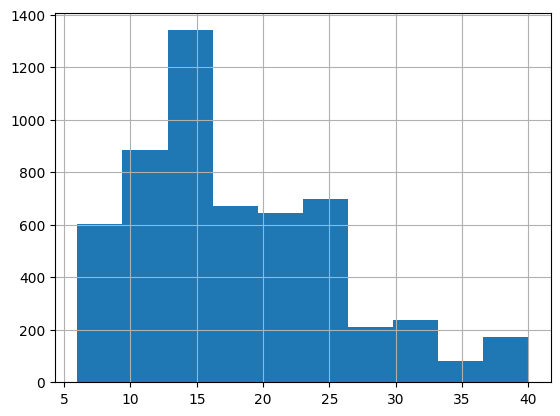

In [17]:
raw_seqns_for_file_with_activities['pep_len'].hist()

In [18]:
raw_seqns_for_file_with_activities = raw_seqns_for_file_with_activities[(raw_seqns_for_file_with_activities['pep_len'] >= 6)&(raw_seqns_for_file_with_activities['pep_len'] <= 40)]

In [19]:
raw_seqns_for_file_with_activities.shape

(5544, 3)

In [20]:
raw_seqns_for_file_with_activities['SEQUENCE'].nunique()

5544

In [21]:
all_for_file_with_activities_2mers = seqns2kmers(sequences_for_file_with_activities, min_len=2, max_len=2, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'AA': 9, 'AG': 1, 'GI': 1, 'IG': 1, 'GK': 2, 'KF': 2, 'FL': 1, 'LH': 1, 'HS': 1, 'SA': 1, 'AK': 1, 'KK': 1, 'FG': 1, 'KA': 1, 'AF': 1, 'FV': 1, 'VG': 1, 'GE': 1, 'EI': 1, 'IM': 1, 'MN': 1, 'NS': 1})
defaultdict(<class 'int'>, {'AA': 6, 'AI': 1, 'IK': 1, 'KM': 1, 'ML': 1, 'LM': 1, 'MD': 1, 'DL': 1, 'LV': 1, 'VN': 1, 'NE': 1, 'ER': 1, 'RI': 1, 'IM': 1, 'MA': 1, 'AL': 1, 'LN': 1, 'NK': 1, 'KK': 2, 'KA': 1, 'AK': 1})
defaultdict(<class 'int'>, {'AA': 3, 'AR': 1, 'RR': 3})
defaultdict(<class 'int'>, {'AA': 1, 'AF': 1, 'FR': 1, 'RG': 1, 'GC': 1, 'CW': 1, 'WT': 1, 'TK': 1, 'KN': 1, 'NY': 1, 'YS': 1, 'SP': 1, 'PK': 1, 'KP': 1, 'PC': 1, 'CL': 1})
defaultdict(<class 'int'>, {'AA': 1, 'AG': 1, 'GK': 1, 'KG': 1, 'GL': 1, 'LV': 1, 'VS': 1, 'SN': 1, 'NL': 1, 'LL': 1, 'LE': 1, 'EK': 1})
defaultdict(<class 'int'>, {'AA': 1, 'AG': 1, 'GK': 1, 'KV': 1, 'VL': 1, 'LK': 2, 'KL': 2, 'LL': 2, 'KK': 1})
defaultdict(<class 'int'>, {'AA': 1, 'AG': 1, 'GM': 1, 'MG': 1, 'GF': 1, 'FF': 

In [22]:
len(all_for_file_with_activities_2mers)

5544

In [23]:
all_for_file_with_activities_2mers_hdr = collect_kmers(all_for_file_with_activities_2mers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5544/5544 [00:00<00:00, 414185.84it/s]


In [24]:
all_for_file_with_activities_2mers_vecs = gen_kmers_vector(all_for_file_with_activities_2mers_hdr, all_for_file_with_activities_2mers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5544/5544 [00:00<00:00, 97916.13it/s]


In [25]:
np.unique(all_for_file_with_activities_2mers_vecs, axis=0).shape

(5472, 400)

In [26]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_2mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Identify duplicate rows
duplicate_mask = counts[unique_inverse] > 1  # Mask for duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Indices of duplicate rows

# Group duplicate indices by their unique identifier
duplicates_dict = defaultdict(list)
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# DataFrame containing original data
df = raw_seqns_for_file_with_activities.copy(deep=True)  # Assuming this contains 'binary_activity'

# Determine which duplicate row to keep
rows_to_keep = set()
rows_to_drop = set()

for indices in duplicates_dict.values():
    if len(indices) > 1:  # Only process actual duplicates
        # Extract the subset of duplicates
        subset = df.loc[indices, ['binary_activity']]

        # Find the index of the row with the maximum binary_activity
        max_idx = subset['binary_activity'].idxmax()

        # Keep this row and mark others for removal
        rows_to_keep.add(max_idx)
        rows_to_drop.update(set(indices) - {max_idx})
    else:
        # If only one occurrence, keep it
        rows_to_keep.add(indices[0])

# Create a new DataFrame without the duplicate rows
df_cleaned = df.drop(index=rows_to_drop)

# Print the final shape
print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")

Original shape: (5544, 3), New shape: (5472, 3)


In [27]:
df_cleaned

,SEQUENCE,binary_activity,pep_len
0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,0.0,33
1,AAAAAAAIKMLMDLVNERIMALNKKAKK,0.0,28
2,AAAARRRR,0.0,8
3,AAFRGCWTKNYSPKPCL,0.0,17
4,AAGKGLVSNLLEK,0.0,13
...,...,...,...
5539,YYHFWHRGVTKRSLSPHRPR,0.0,20
5540,YYHFWHRGVTKRSLSPHRPRHSR,1.0,23
5541,YYHFWHRGVTKRSLSPHRPRHSRLQR,1.0,26
5542,YYQVSEERRRDLASLARLYALAR,0.0,23


In [28]:
df_cleaned['binary_activity']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5539    0.0
5540    1.0
5541    1.0
5542    0.0
5543    0.0
Name: binary_activity, Length: 5472, dtype: float64

In [29]:
sequences_for_file_with_activities = df_cleaned[sequence_column].to_list()

In [30]:
all_for_file_with_activities_2mers = seqns2kmers(sequences_for_file_with_activities, min_len=2, max_len=2, shift=1, normalize=False, binarized=False)
all_for_file_with_activities_2mers_vecs = gen_kmers_vector(all_for_file_with_activities_2mers_hdr, all_for_file_with_activities_2mers)

defaultdict(<class 'int'>, {'AA': 9, 'AG': 1, 'GI': 1, 'IG': 1, 'GK': 2, 'KF': 2, 'FL': 1, 'LH': 1, 'HS': 1, 'SA': 1, 'AK': 1, 'KK': 1, 'FG': 1, 'KA': 1, 'AF': 1, 'FV': 1, 'VG': 1, 'GE': 1, 'EI': 1, 'IM': 1, 'MN': 1, 'NS': 1})
defaultdict(<class 'int'>, {'AA': 6, 'AI': 1, 'IK': 1, 'KM': 1, 'ML': 1, 'LM': 1, 'MD': 1, 'DL': 1, 'LV': 1, 'VN': 1, 'NE': 1, 'ER': 1, 'RI': 1, 'IM': 1, 'MA': 1, 'AL': 1, 'LN': 1, 'NK': 1, 'KK': 2, 'KA': 1, 'AK': 1})
defaultdict(<class 'int'>, {'AA': 3, 'AR': 1, 'RR': 3})
defaultdict(<class 'int'>, {'AA': 1, 'AF': 1, 'FR': 1, 'RG': 1, 'GC': 1, 'CW': 1, 'WT': 1, 'TK': 1, 'KN': 1, 'NY': 1, 'YS': 1, 'SP': 1, 'PK': 1, 'KP': 1, 'PC': 1, 'CL': 1})
defaultdict(<class 'int'>, {'AA': 1, 'AG': 1, 'GK': 1, 'KG': 1, 'GL': 1, 'LV': 1, 'VS': 1, 'SN': 1, 'NL': 1, 'LL': 1, 'LE': 1, 'EK': 1})
defaultdict(<class 'int'>, {'AA': 1, 'AG': 1, 'GK': 1, 'KV': 1, 'VL': 1, 'LK': 2, 'KL': 2, 'LL': 2, 'KK': 1})
defaultdict(<class 'int'>, {'AA': 1, 'AG': 1, 'GM': 1, 'MG': 1, 'GF': 1, 'FF': 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5472/5472 [00:00<00:00, 121284.28it/s]


In [31]:
# Ev
# Convert binary_activity column to numeric, handling potential string values
#df_cleaned["binary_activity"] = pd.to_numeric(df_cleaned["binary_activity"], errors='coerce')

# Ensure the values are properly converted to integers
binary_activity_array = df_cleaned["binary_activity"].to_numpy()

# Save as NPZ file
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity=binary_activity_array)

In [32]:
np.savez(npz_file_with_activities, vectors=all_for_file_with_activities_2mers_vecs)

In [33]:
binary_activity_array.shape

(5472,)

In [34]:
all_for_file_with_activities_2mers_vecs.shape

(5472, 400)

In [35]:
np.unique(all_for_file_with_activities_2mers_vecs, axis=0).shape

(5472, 400)

In [36]:
indices_for_file_with_activities_2mers = [str(i+1) for i in range(all_for_file_with_activities_2mers_vecs.shape[0])]

In [37]:
desc_2mers_hdr = collect_kmers(all_for_file_with_activities_2mers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5472/5472 [00:00<00:00, 457086.58it/s]


In [38]:
len(desc_2mers_hdr)

400

In [39]:
write_hdr(desc_2mers_hdr, open(hdr_for_file_with_activities, "w"))

In [40]:
!head /data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/2mers.hdr

1.                                                                                                                            AA
2.                                                                                                                            AC
3.                                                                                                                            AD
4.                                                                                                                            AE
5.                                                                                                                            AF
6.                                                                                                                            AG
7.                                                                                                                            AH
8.                                                                                               

#### Model

In [41]:
vectors_path = ["/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/2mers.npz"]
results_path = ["/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/prediction_2mers.csv"]
activities_path = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/binary_activity.npz"
pickle_path = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/QSAR/"

In [42]:
!ls /data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/QSAR/

model_RF_2mers.pickle


In [ ]:
for vec, res in tqdm(zip(vectors_path, results_path)):
    benchmark(vec, res, activities_path, pickle_path, use_mlp=False)

0it [00:00, ?it/s]

In [ ]:
# File path
file_path = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/QSAR/model_RF_2mers.pickle"

# Load the model2mers.hdr
with open(file_path, "rb") as f:
    model = pickle.load(f)

# Print the loaded model (optional)
print(model)

In [ ]:
!head /data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_s_aureus_length_6_40_activity_thresholds_10_and_15/prediction_2mers.csv

### Generate 3mers

In [47]:
hdr_for_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/3mers.hdr"
npz_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/3mers.npz"
svm_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/3mers.svm"
simplified_hdr_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/3mers_simplified.hdr"

In [48]:
raw_seqns_for_file_with_activities = pd.read_csv(file_with_activities, dtype=str)
sequences_for_file_with_activities = raw_seqns_for_file_with_activities[sequence_column].to_list()

In [49]:
raw_seqns_for_file_with_activities.index

RangeIndex(start=0, stop=2011, step=1)

In [50]:
raw_seqns_for_file_with_activities.shape

(2011, 46)

In [51]:
raw_seqns_for_file_with_activities['SEQUENCE'].nunique()

2011

In [52]:
all_for_file_with_activities_3mers = seqns2kmers(sequences_for_file_with_activities, min_len=3, max_len=3, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'LWK': 1, 'WKT': 1, 'KTL': 1, 'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'WKT': 1, 'KTL': 1, 'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'KTL': 1, 'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'FKR': 1, 'KRI': 1, 'RIV': 1, 'IVQ': 1, 'VQR': 1, 'QRI': 1, 'RIK': 1, 'IKD': 1, 'KDF': 1, 'DFL': 1, 'FLR': 1})
defaultdict(<class 'int'>, {'KRI': 1, 'RIV': 1, 'IVQ': 1, 'VQR': 1, 'QRI': 1, 'RIK': 1, 'IKD': 1, 'KDF': 1, 'DFL': 1, 'FLR': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1, 'KRK': 1, 'RKR': 1, 'KRF': 1, 'RFI': 1, 'FIF': 1, 'IFI': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1,

In [53]:
len(all_for_file_with_activities_3mers)

2011

In [54]:
all_for_file_with_activities_3mers_hdr = collect_kmers(all_for_file_with_activities_3mers)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2011/2011 [00:00<00:00, 405146.52it/s]


In [55]:
all_for_file_with_activities_3mers_vecs = gen_kmers_vector(all_for_file_with_activities_3mers_hdr, all_for_file_with_activities_3mers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2011/2011 [00:00<00:00, 51775.17it/s]


In [56]:
np.unique(all_for_file_with_activities_3mers_vecs, axis=0).shape

(2005, 2687)

In [57]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_3mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Get duplicate row indices
duplicate_mask = counts[unique_inverse] > 1  # Mask to identify duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Get the indices of duplicate rows

# Create pairs of duplicate indices
from collections import defaultdict

duplicates_dict = defaultdict(list)

# Group indices of duplicates by their unique representation
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# Convert to list of pairs
duplicate_pairs = [tuple(indices) for indices in duplicates_dict.values() if len(indices) > 1]

# Print duplicate pairs
for pair in duplicate_pairs:
    print(pair)
    print(raw_seqns_for_file_with_activities.loc[list(pair), ['SEQUENCE', 'binary_activity', 'molar_concentration_mean']])

(351, 620)
           SEQUENCE binary_activity molar_concentration_mean
351  KWKKPLLKKLLKKL             1.0                     6.25
620  KWKKLLKKPLLKKL             1.0                      NaN
(813, 815)
           SEQUENCE binary_activity molar_concentration_mean
813  KLPKLLKKLLKLLK             0.0                     10.0
815  KLLKLLKKLPKLLK             0.0                     40.0
(1067, 1068)
          SEQUENCE binary_activity molar_concentration_mean
1067  KKKVVFKVKFKK             1.0        2.079734219269103
1068  KKVVFKVKFKKK             1.0        2.079734219269103
(1149, 1152)
         SEQUENCE binary_activity molar_concentration_mean
1149  LKWLKKLLKKL             1.0          1.4194464158978
1152  LKKLLKWLKKL             1.0          1.4194464158978
(1150, 1153)
         SEQUENCE binary_activity molar_concentration_mean
1150  LLKWLKKLLKK             1.0          1.4194464158978
1153  LLKKLLKWLKK             1.0          1.4194464158978
(1151, 1154)
         SEQUENCE binary_a

In [58]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_3mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Identify duplicate rows
duplicate_mask = counts[unique_inverse] > 1  # Mask for duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Indices of duplicate rows

# Group duplicate indices by their unique identifier
duplicates_dict = defaultdict(list)
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# DataFrame containing original data
df = raw_seqns_for_file_with_activities.copy(deep=True)  # Assuming this contains 'binary_activity'

# Determine which duplicate row to keep
rows_to_keep = set()
rows_to_drop = set()

for indices in duplicates_dict.values():
    if len(indices) > 1:  # Only process actual duplicates
        # Extract the subset of duplicates
        subset = df.loc[indices, ['binary_activity']]

        # Find the index of the row with the maximum binary_activity
        max_idx = subset['binary_activity'].idxmax()

        # Keep this row and mark others for removal
        rows_to_keep.add(max_idx)
        rows_to_drop.update(set(indices) - {max_idx})
    else:
        # If only one occurrence, keep it
        rows_to_keep.add(indices[0])

# Create a new DataFrame without the duplicate rows
df_cleaned = df.drop(index=rows_to_drop)

# Print the final shape
print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")

Original shape: (2011, 46), New shape: (2005, 46)


In [59]:
df_cleaned

,ID,UNIRPROT - ID,PDB NAME,SEQUENCE,TARGET ACTIVITY - CONCENTRATION,TARGET ACTIVITY - UNIT,COMPLEXITY,NAME,SYNTHESIS TYPE,TARGET GROUP,...,SYNERGY - REFERENCE,pep_id,monomer_mass,molar_concentration,extracted_relation,extracted_value,binary_activity,species_agg,molar_concentration_mean,pep_len
0,82,NaN,NaN,LWKTLLKKVLKAAA,3,µM,Monomer,NC12- Dermaseptin S4 (2-15)AMD[M4K],Synthetic,"Gram+,Gram-",...,NaN,175,1581,3.0,=,3,1.0,Staphylococcus aureus,NaN,14
1,87,NaN,NaN,WKTLLKKVLKAAA,3,µM,Monomer,NC12- Dermaseptin S4 (3-15)AMD[M4K],Synthetic,"Gram+,Gram-",...,NaN,195,1468,3.0,=,3,1.0,Staphylococcus aureus,NaN,13
2,92,NaN,NaN,KTLLKKVLKAAA,12.5,µM,Monomer,NC12- Dermaseptin S4 (4-15)AMD[M4K],Synthetic,"Gram+,Gram-",...,NaN,223,1282,12.5,=,12.5,0.0,Staphylococcus aureus,NaN,12
3,97,NaN,NaN,TLLKKVLKAAA,50,µM,Monomer,NC12- Dermaseptin S4 (5-15)AMD,Synthetic,"Gram+,Gram-",...,NaN,243,1154,50.0,=,50,0.0,Staphylococcus aureus,NaN,11
4,144,NaN,6S6M,FKRIVQRIKDFLR,40,µM,Monomer,LL-37 (17-29),Synthetic,"Gram+,Gram-,Virus,Mammalian Cell",...,NaN,385,1717,40.0,=,40,0.0,Staphylococcus aureus,NaN,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,19012,NaN,NaN,KAIAAFAKKFFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13FF], MpVT5",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75148,1353,36.95491500369549,>,50.0,0.0,Staphylococcus aureus,36.95491500369549,12
2007,19013,NaN,NaN,KAIAAFAKALFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K12A,F14Ins], MpVT6",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75154,1262,39.61965134706814,>,50.0,0.0,Staphylococcus aureus,39.61965134706814,12
2008,19014,NaN,NaN,KAIAAFAAKLFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K11A,F14Ins], MpVT7",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75160,1262,39.61965134706814,>,50.0,0.0,Staphylococcus aureus,39.61965134706814,12
2009,19127,Q71MD7,NaN,GFFKKAKRKVKKAG,>128,µg/ml,Monomer,"HFIAP-1 (1-14)[W7K,H12K]",Synthetic,"Gram+,Gram-",...,NaN,75539,1591,80.45254556882465,>,128.0,0.0,Staphylococcus aureus,80.45254556882465,14


In [60]:
sequences_for_file_with_activities = df_cleaned[sequence_column].to_list()

In [62]:
# Ev
# Convert binary_activity column to numeric, handling potential string values
df_cleaned["binary_activity"] = pd.to_numeric(df_cleaned["binary_activity"], errors='coerce')

# Ensure the values are properly converted to integers
binary_activity_array = df_cleaned["binary_activity"].fillna(0).astype(float).round().astype(int).to_numpy()

# Save as NPZ file
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity=binary_activity_array)

In [63]:
binary_activity_array = df_cleaned["binary_activity"].astype(int).to_numpy()
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity = binary_activity_array)

In [64]:
np.savez(npz_file_with_activities, vectors=all_for_file_with_activities_3mers_vecs)

In [65]:
binary_activity_array.shape

(2005,)

In [66]:
all_for_file_with_activities_3mers_vecs.shape

(2011, 2687)

In [67]:
all_for_file_with_activities_3mers = seqns2kmers(df_cleaned['SEQUENCE'], min_len=3, max_len=3, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'LWK': 1, 'WKT': 1, 'KTL': 1, 'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'WKT': 1, 'KTL': 1, 'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'KTL': 1, 'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'TLL': 1, 'LLK': 1, 'LKK': 1, 'KKV': 1, 'KVL': 1, 'VLK': 1, 'LKA': 1, 'KAA': 1, 'AAA': 1})
defaultdict(<class 'int'>, {'FKR': 1, 'KRI': 1, 'RIV': 1, 'IVQ': 1, 'VQR': 1, 'QRI': 1, 'RIK': 1, 'IKD': 1, 'KDF': 1, 'DFL': 1, 'FLR': 1})
defaultdict(<class 'int'>, {'KRI': 1, 'RIV': 1, 'IVQ': 1, 'VQR': 1, 'QRI': 1, 'RIK': 1, 'IKD': 1, 'KDF': 1, 'DFL': 1, 'FLR': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1, 'KRK': 1, 'RKR': 1, 'KRF': 1, 'RFI': 1, 'FIF': 1, 'IFI': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1,

In [68]:
all_for_file_with_activities_3mers_hdr = collect_kmers(all_for_file_with_activities_3mers)
all_for_file_with_activities_3mers_vecs = gen_kmers_vector(all_for_file_with_activities_3mers_hdr, all_for_file_with_activities_3mers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2005/2005 [00:00<00:00, 85230.21it/s]


In [69]:
np.unique(all_for_file_with_activities_3mers_vecs, axis=0).shape

(2005, 2687)

In [70]:
vectors_path ='/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/3mers.npz'

In [71]:
np.savez(vectors_path, vectors=all_for_file_with_activities_3mers_vecs)

In [72]:
indices_for_file_with_activities_3mers = [str(i+1) for i in range(all_for_file_with_activities_3mers_vecs.shape[0])]

In [73]:
vectors_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/3mers.npz"]
results_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/prediction_3mers.csv"]
activities_path = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/binary_activity.npz"
pickle_path = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/QSAR/"

In [74]:
for vec, res in tqdm(zip(vectors_path, results_path)):
    benchmark(vec, res, activities_path, pickle_path, use_mlp=False)

1it [34:27, 2067.44s/it]


In [75]:
# File path
file_path = "/data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/QSAR/model_RF_3mers.pickle"

# Load the model
with open(file_path, "rb") as f:
    model = pickle.load(f)

# Print the loaded model (optional)
print(model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500))])


In [76]:
!head /data/emilova/peptides/src/data/DBAASP/test_for_s_aureus_alternative_data_extraction_mole/prediction_3mers.csv

BA_SVM,ROCAUC_SVM,BA_RF,ROCAUC_RF
0.6859922960645879,0.7583414538979927,0.7202353797726172,0.7979558281867717


## Pseudomonas aeruginosa 

### Train set peptides

In [48]:
file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/file_with_activities.csv"
sequence_column = "SEQUENCE" 

### Names of all files to be created

In [49]:
hdr_for_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/2mers.hdr"
npz_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/2mers.npz"
svm_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/2mers.svm"
simplified_hdr_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/2mers_simplified.hdr"

### Generate 2mers

In [50]:
raw_seqns_for_file_with_activities = pd.read_csv(file_with_activities, dtype=str)
sequences_for_file_with_activities = raw_seqns_for_file_with_activities[sequence_column].to_list()

In [51]:
raw_seqns_for_file_with_activities.index

RangeIndex(start=0, stop=1469, step=1)

In [52]:
raw_seqns_for_file_with_activities['pep_len'] = raw_seqns_for_file_with_activities['SEQUENCE'].str.len()

<Axes: >

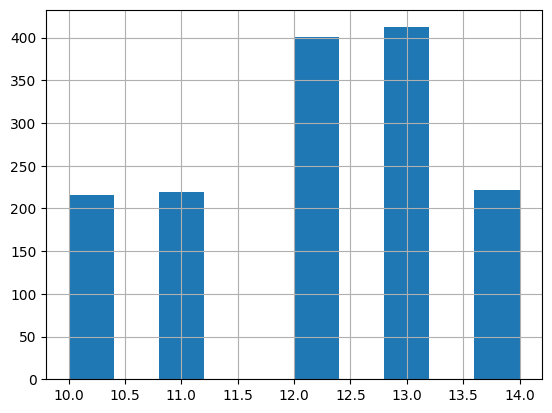

In [53]:
raw_seqns_for_file_with_activities['pep_len'].hist()

In [54]:
raw_seqns_for_file_with_activities = raw_seqns_for_file_with_activities[(raw_seqns_for_file_with_activities['pep_len'] >= 6)&(raw_seqns_for_file_with_activities['pep_len'] <= 40)]

In [55]:
raw_seqns_for_file_with_activities.shape

(1469, 46)

In [56]:
raw_seqns_for_file_with_activities['SEQUENCE'].nunique()

1469

In [57]:
all_for_file_with_activities_2mers = seqns2kmers(sequences_for_file_with_activities, min_len=2, max_len=2, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'FK': 1, 'KR': 1, 'RI': 2, 'IV': 1, 'VQ': 1, 'QR': 1, 'IK': 1, 'KD': 1, 'DF': 1, 'FL': 1, 'LR': 1})
defaultdict(<class 'int'>, {'YV': 1, 'VL': 1, 'LW': 1, 'WK': 1, 'KR': 2, 'RK': 1, 'RF': 1, 'FI': 2, 'IF': 1})
defaultdict(<class 'int'>, {'YV': 1, 'VL': 1, 'LW': 1, 'WK': 1, 'KR': 2, 'RK': 1, 'RW': 1, 'WI': 1, 'IF': 1, 'FI': 1})
defaultdict(<class 'int'>, {'KK': 2, 'KL': 1, 'LF': 1, 'FK': 1, 'KI': 1, 'IL': 1, 'LK': 1, 'KY': 1, 'YL': 1})
defaultdict(<class 'int'>, {'IL': 1, 'LP': 1, 'PW': 3, 'WK': 1, 'KW': 1, 'WP': 2, 'WW': 1, 'WR': 1, 'RR': 1})
defaultdict(<class 'int'>, {'RL': 1, 'LA': 1, 'AR': 2, 'RI': 1, 'IV': 1, 'VV': 1, 'VI': 1, 'IR': 1, 'RV': 1, 'VA': 1})
defaultdict(<class 'int'>, {'FL': 1, 'LP': 1, 'PL': 1, 'LI': 1, 'IG': 1, 'GR': 1, 'RV': 1, 'VL': 1, 'LS': 1, 'SG': 1, 'GI': 1, 'IL': 1})
defaultdict(<class 'int'>, {'LL': 3, 'LP': 1, 'PI': 1, 'IV': 1, 'VG': 1, 'GN': 1, 'NL': 1, 'LK': 1, 'KS': 1, 'SL': 1})
defaultdict(<class 'int'>, {'FV': 1, 'VQ': 1, 'Q

In [58]:
len(all_for_file_with_activities_2mers)

1469

In [59]:
all_for_file_with_activities_2mers_hdr = collect_kmers(all_for_file_with_activities_2mers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:00<00:00, 476227.59it/s]


In [60]:
all_for_file_with_activities_2mers_vecs = gen_kmers_vector(all_for_file_with_activities_2mers_hdr, all_for_file_with_activities_2mers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:00<00:00, 100634.25it/s]


In [61]:
np.unique(all_for_file_with_activities_2mers_vecs, axis=0).shape

(1447, 367)

In [62]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_2mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Get duplicate row indices
duplicate_mask = counts[unique_inverse] > 1  # Mask to identify duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Get the indices of duplicate rows

# Create pairs of duplicate indices
from collections import defaultdict

duplicates_dict = defaultdict(list)

# Group indices of duplicates by their unique representation
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# Convert to list of pairs
duplicate_pairs = [tuple(indices) for indices in duplicates_dict.values() if len(indices) > 1]

# Print duplicate pairs
for pair in duplicate_pairs:
    print(pair)
    print(raw_seqns_for_file_with_activities.loc[list(pair), ['SEQUENCE', 'binary_activity', 'molar_concentration_mean']])

(132, 133)
          SEQUENCE binary_activity molar_concentration_mean
132  ILPWKWAWWPWRR             0.0                     50.0
133  ILPWKWPWWAWRR             0.0                     50.0
(213, 214)
          SEQUENCE binary_activity molar_concentration_mean
213  ILAWKWAWWPWRR             0.0                    100.0
214  ILAWKWPWWAWRR             0.0                    100.0
(259, 261)
          SEQUENCE binary_activity molar_concentration_mean
259  ILSLRWRWKWWKK             0.0                     32.0
261  ILSLRWRWWKWKK             0.0                     32.0
(264, 303)
       SEQUENCE binary_activity molar_concentration_mean
264  WKWWKKWWKK             0.0                     10.0
303  WKKWWKKWWK             0.0                     15.6
(301, 783)
         SEQUENCE binary_activity molar_concentration_mean
301  LKKLLKKLLKKL             1.0                     7.81
783  KLKKLLKKLLKK             0.0       169.03313049357675
(355, 853)
         SEQUENCE binary_activity molar_concen

In [63]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_2mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Identify duplicate rows
duplicate_mask = counts[unique_inverse] > 1  # Mask for duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Indices of duplicate rows

# Group duplicate indices by their unique identifier
duplicates_dict = defaultdict(list)
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# DataFrame containing original data
df = raw_seqns_for_file_with_activities.copy(deep=True)  # Assuming this contains 'binary_activity'

# Determine which duplicate row to keep
rows_to_keep = set()
rows_to_drop = set()

for indices in duplicates_dict.values():
    if len(indices) > 1:  # Only process actual duplicates
        # Extract the subset of duplicates
        subset = df.loc[indices, ['binary_activity']]

        # Find the index of the row with the maximum binary_activity
        max_idx = subset['binary_activity'].idxmax()

        # Keep this row and mark others for removal
        rows_to_keep.add(max_idx)
        rows_to_drop.update(set(indices) - {max_idx})
    else:
        # If only one occurrence, keep it
        rows_to_keep.add(indices[0])

# Create a new DataFrame without the duplicate rows
df_cleaned = df.drop(index=rows_to_drop)

# Print the final shape
print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")

Original shape: (1469, 46), New shape: (1447, 46)


In [64]:
df_cleaned

,ID,UNIRPROT - ID,PDB NAME,SEQUENCE,TARGET ACTIVITY - CONCENTRATION,TARGET ACTIVITY - UNIT,COMPLEXITY,NAME,SYNTHESIS TYPE,TARGET GROUP,...,SYNERGY - REFERENCE,pep_id,monomer_mass,molar_concentration,extracted_relation,extracted_value,binary_activity,species_agg,molar_concentration_mean,pep_len
0,144,NaN,6S6M,FKRIVQRIKDFLR,116.28,µM,Monomer,LL-37 (17-29),Synthetic,"Gram+,Gram-,Virus,Mammalian Cell",...,NaN,380,1717,116.28,=,116.28,0.0,Pseudomonas aeruginosa,116.28,13
1,189,NaN,NaN,YVLWKRKRFIFI,30,µM,Monomer,NaN,Synthetic,"Gram+,Gram-",...,NaN,674,1667,30.0,=,30,0.0,Pseudomonas aeruginosa,30.0,12
2,190,NaN,NaN,YVLWKRKRWIFI,150,µM,Monomer,NaN,Synthetic,"Gram+,Gram-",...,NaN,678,1706,150.0,=,150,0.0,Pseudomonas aeruginosa,150.0,12
3,197,NaN,NaN,KKLFKKILKYL,5,µM,Monomer,BP100,Synthetic,"Gram+,Gram-,Cancer,Fungus,Mammalian Cell",...,NaN,727,1420,5.0,=,5,1.0,Pseudomonas aeruginosa,5.0,11
4,491,NaN,1G8C,ILPWKWPWWPWRR,32,µM,Monomer,"Cathelicidin-4, Indolicidin",Ribosomal,"Gram+,Gram-,Virus,Parasite,Cancer,Fungus,Mamma...",...,NaN,2150,1905,32.0,=,32,0.0,Pseudomonas aeruginosa,32.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,18320,NaN,NaN,RVCVWLVVMCKK,>128,µg/ml,Monomer,RP513,Synthetic,"Gram+,Gram-,Fungus",...,NaN,73203,1462,87.55129958960327,>,128.0,0.0,Pseudomonas aeruginosa,87.55129958960327,12
1465,19012,P0C1Q7,NaN,KAIAAFAKKFFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13FF], MpVT5",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75147,1353,36.95491500369549,>,50.0,0.0,Pseudomonas aeruginosa,36.95491500369549,12
1466,19013,P0C1Q7,NaN,KAIAAFAKALFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K12A,F14Ins], MpVT6",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75153,1262,39.61965134706814,>,50.0,0.0,Pseudomonas aeruginosa,39.61965134706814,12
1467,19014,P0C1Q7,NaN,KAIAAFAAKLFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K11A,F14Ins], MpVT7",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75159,1262,39.61965134706814,>,50.0,0.0,Pseudomonas aeruginosa,39.61965134706814,12


In [65]:
sequences_for_file_with_activities = df_cleaned[sequence_column].to_list()

In [66]:
all_for_file_with_activities_2mers = seqns2kmers(sequences_for_file_with_activities, min_len=2, max_len=2, shift=1, normalize=False, binarized=False)
all_for_file_with_activities_2mers_vecs = gen_kmers_vector(all_for_file_with_activities_2mers_hdr, all_for_file_with_activities_2mers)

defaultdict(<class 'int'>, {'FK': 1, 'KR': 1, 'RI': 2, 'IV': 1, 'VQ': 1, 'QR': 1, 'IK': 1, 'KD': 1, 'DF': 1, 'FL': 1, 'LR': 1})
defaultdict(<class 'int'>, {'YV': 1, 'VL': 1, 'LW': 1, 'WK': 1, 'KR': 2, 'RK': 1, 'RF': 1, 'FI': 2, 'IF': 1})
defaultdict(<class 'int'>, {'YV': 1, 'VL': 1, 'LW': 1, 'WK': 1, 'KR': 2, 'RK': 1, 'RW': 1, 'WI': 1, 'IF': 1, 'FI': 1})
defaultdict(<class 'int'>, {'KK': 2, 'KL': 1, 'LF': 1, 'FK': 1, 'KI': 1, 'IL': 1, 'LK': 1, 'KY': 1, 'YL': 1})
defaultdict(<class 'int'>, {'IL': 1, 'LP': 1, 'PW': 3, 'WK': 1, 'KW': 1, 'WP': 2, 'WW': 1, 'WR': 1, 'RR': 1})
defaultdict(<class 'int'>, {'RL': 1, 'LA': 1, 'AR': 2, 'RI': 1, 'IV': 1, 'VV': 1, 'VI': 1, 'IR': 1, 'RV': 1, 'VA': 1})
defaultdict(<class 'int'>, {'FL': 1, 'LP': 1, 'PL': 1, 'LI': 1, 'IG': 1, 'GR': 1, 'RV': 1, 'VL': 1, 'LS': 1, 'SG': 1, 'GI': 1, 'IL': 1})
defaultdict(<class 'int'>, {'LL': 3, 'LP': 1, 'PI': 1, 'IV': 1, 'VG': 1, 'GN': 1, 'NL': 1, 'LK': 1, 'KS': 1, 'SL': 1})
defaultdict(<class 'int'>, {'FV': 1, 'VQ': 1, 'Q

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1447/1447 [00:00<00:00, 177533.43it/s]


In [67]:
# Ev
# Convert binary_activity column to numeric, handling potential string values
df_cleaned["binary_activity"] = pd.to_numeric(df_cleaned["binary_activity"], errors='coerce')

# Ensure the values are properly converted to integers
binary_activity_array = df_cleaned["binary_activity"].fillna(0).astype(float).round().astype(int).to_numpy()

# Save as NPZ file
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity=binary_activity_array)

In [68]:
binary_activity_array = df_cleaned["binary_activity"].astype(int).to_numpy()
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity = binary_activity_array)

In [69]:
np.savez(npz_file_with_activities, vectors=all_for_file_with_activities_2mers_vecs)

In [70]:
binary_activity_array.shape

(1447,)

In [71]:
all_for_file_with_activities_2mers_vecs.shape

(1447, 367)

In [72]:
np.unique(all_for_file_with_activities_2mers_vecs, axis=0).shape

(1447, 367)

In [73]:
indices_for_file_with_activities_2mers = [str(i+1) for i in range(all_for_file_with_activities_2mers_vecs.shape[0])]

In [74]:
desc_2mers_hdr = collect_kmers(all_for_file_with_activities_2mers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1447/1447 [00:00<00:00, 419546.38it/s]


In [75]:
write_hdr(desc_2mers_hdr, open(hdr_for_file_with_activities, "w"))

In [76]:
len(desc_2mers_hdr)

367

#### Model

In [104]:
vectors_path = ["/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/2mers.npz"]
results_path = ["/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/prediction_2mers.csv"]
activities_path = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/binary_activity.npz"
pickle_path = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/QSAR/"

In [105]:
for vec, res in tqdm(zip(vectors_path, results_path)):
    benchmark(vec, res, activities_path, pickle_path, use_mlp=False)

1it [02:11, 131.16s/it]


In [106]:
# File path
file_path = "/data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/QSAR/model_RF_2mers.pickle"

# Load the model
with open(file_path, "rb") as f:
    model = pickle.load(f)

# Print the loaded model (optional)
print(model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=250))])


In [107]:
!head /data/emilova/peptides/src/data/DBAASP/alternative_data_extraction_species_mole_p_aeruginosa_length_6_40_activity_thresholds_10_and_15/prediction_2mers.csv

BA_SVM,ROCAUC_SVM,BA_RF,ROCAUC_RF
0.724572331502156,0.8004031543505228,0.7074936499497901,0.834158692185008


### Generate 3mers

In [108]:
hdr_for_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/3mers.hdr"
npz_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/3mers.npz"
svm_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/3mers.svm"
simplified_hdr_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/3mers_simplified.hdr"

In [109]:
raw_seqns_for_file_with_activities = pd.read_csv(file_with_activities, dtype=str)
sequences_for_file_with_activities = raw_seqns_for_file_with_activities[sequence_column].to_list()

In [110]:
raw_seqns_for_file_with_activities.index

RangeIndex(start=0, stop=1469, step=1)

In [111]:
raw_seqns_for_file_with_activities.shape

(1469, 46)

In [112]:
raw_seqns_for_file_with_activities['SEQUENCE'].nunique()

1469

In [113]:
all_for_file_with_activities_3mers = seqns2kmers(sequences_for_file_with_activities, min_len=3, max_len=3, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'FKR': 1, 'KRI': 1, 'RIV': 1, 'IVQ': 1, 'VQR': 1, 'QRI': 1, 'RIK': 1, 'IKD': 1, 'KDF': 1, 'DFL': 1, 'FLR': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1, 'KRK': 1, 'RKR': 1, 'KRF': 1, 'RFI': 1, 'FIF': 1, 'IFI': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1, 'KRK': 1, 'RKR': 1, 'KRW': 1, 'RWI': 1, 'WIF': 1, 'IFI': 1})
defaultdict(<class 'int'>, {'KKL': 1, 'KLF': 1, 'LFK': 1, 'FKK': 1, 'KKI': 1, 'KIL': 1, 'ILK': 1, 'LKY': 1, 'KYL': 1})
defaultdict(<class 'int'>, {'ILP': 1, 'LPW': 1, 'PWK': 1, 'WKW': 1, 'KWP': 1, 'WPW': 2, 'PWW': 1, 'WWP': 1, 'PWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'RLA': 1, 'LAR': 1, 'ARI': 1, 'RIV': 1, 'IVV': 1, 'VVI': 1, 'VIR': 1, 'IRV': 1, 'RVA': 1, 'VAR': 1})
defaultdict(<class 'int'>, {'FLP': 1, 'LPL': 1, 'PLI': 1, 'LIG': 1, 'IGR': 1, 'GRV': 1, 'RVL': 1, 'VLS': 1, 'LSG': 1, 'SGI': 1, 'GIL': 1})
defaultdict(<class 'int'>, {'LLP': 1, 'LPI': 1, 'PIV': 1, 'IVG': 1, 'VGN': 1, 'GNL': 1,

In [114]:
len(all_for_file_with_activities_3mers)

1469

In [115]:
all_for_file_with_activities_3mers_hdr = collect_kmers(all_for_file_with_activities_3mers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:00<00:00, 390606.86it/s]


In [116]:
all_for_file_with_activities_3mers_vecs = gen_kmers_vector(all_for_file_with_activities_3mers_hdr, all_for_file_with_activities_3mers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:00<00:00, 83030.34it/s]


In [117]:
np.unique(all_for_file_with_activities_3mers_vecs, axis=0).shape

(1466, 2157)

In [118]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_3mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Get duplicate row indices
duplicate_mask = counts[unique_inverse] > 1  # Mask to identify duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Get the indices of duplicate rows

# Create pairs of duplicate indices
from collections import defaultdict

duplicates_dict = defaultdict(list)

# Group indices of duplicates by their unique representation
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# Convert to list of pairs
duplicate_pairs = [tuple(indices) for indices in duplicates_dict.values() if len(indices) > 1]

# Print duplicate pairs
for pair in duplicate_pairs:
    print(pair)
    print(raw_seqns_for_file_with_activities.loc[list(pair), ['SEQUENCE', 'binary_activity', 'molar_concentration_mean']])

(726, 729)
        SEQUENCE binary_activity molar_concentration_mean
726  LKWLKKLLKKL             1.0          5.6777856635912
729  LKKLLKWLKKL             1.0          5.6777856635912
(727, 730)
        SEQUENCE binary_activity molar_concentration_mean
727  LLKWLKKLLKK             1.0          2.8388928317956
730  LLKKLLKWLKK             1.0          5.6777856635912
(728, 731)
        SEQUENCE binary_activity molar_concentration_mean
728  KLLKWLKKLLK             1.0          5.6777856635912
731  KLLKKLLKWLK             1.0          2.8388928317956


In [119]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_3mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Identify duplicate rows
duplicate_mask = counts[unique_inverse] > 1  # Mask for duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Indices of duplicate rows

# Group duplicate indices by their unique identifier
duplicates_dict = defaultdict(list)
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# DataFrame containing original data
df = raw_seqns_for_file_with_activities.copy(deep=True)  # Assuming this contains 'binary_activity'

# Determine which duplicate row to keep
rows_to_keep = set()
rows_to_drop = set()

for indices in duplicates_dict.values():
    if len(indices) > 1:  # Only process actual duplicates
        # Extract the subset of duplicates
        subset = df.loc[indices, ['binary_activity']]

        # Find the index of the row with the maximum binary_activity
        max_idx = subset['binary_activity'].idxmax()

        # Keep this row and mark others for removal
        rows_to_keep.add(max_idx)
        rows_to_drop.update(set(indices) - {max_idx})
    else:
        # If only one occurrence, keep it
        rows_to_keep.add(indices[0])

# Create a new DataFrame without the duplicate rows
df_cleaned = df.drop(index=rows_to_drop)

# Print the final shape
print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")

Original shape: (1469, 46), New shape: (1466, 46)


In [120]:
df_cleaned

,ID,UNIRPROT - ID,PDB NAME,SEQUENCE,TARGET ACTIVITY - CONCENTRATION,TARGET ACTIVITY - UNIT,COMPLEXITY,NAME,SYNTHESIS TYPE,TARGET GROUP,...,SYNERGY - REFERENCE,pep_id,monomer_mass,molar_concentration,extracted_relation,extracted_value,binary_activity,species_agg,molar_concentration_mean,pep_len
0,144,NaN,6S6M,FKRIVQRIKDFLR,116.28,µM,Monomer,LL-37 (17-29),Synthetic,"Gram+,Gram-,Virus,Mammalian Cell",...,NaN,380,1717,116.28,=,116.28,0.0,Pseudomonas aeruginosa,116.28,13
1,189,NaN,NaN,YVLWKRKRFIFI,30,µM,Monomer,NaN,Synthetic,"Gram+,Gram-",...,NaN,674,1667,30.0,=,30,0.0,Pseudomonas aeruginosa,30.0,12
2,190,NaN,NaN,YVLWKRKRWIFI,150,µM,Monomer,NaN,Synthetic,"Gram+,Gram-",...,NaN,678,1706,150.0,=,150,0.0,Pseudomonas aeruginosa,150.0,12
3,197,NaN,NaN,KKLFKKILKYL,5,µM,Monomer,BP100,Synthetic,"Gram+,Gram-,Cancer,Fungus,Mammalian Cell",...,NaN,727,1420,5.0,=,5,1.0,Pseudomonas aeruginosa,5.0,11
4,491,NaN,1G8C,ILPWKWPWWPWRR,32,µM,Monomer,"Cathelicidin-4, Indolicidin",Ribosomal,"Gram+,Gram-,Virus,Parasite,Cancer,Fungus,Mamma...",...,NaN,2150,1905,32.0,=,32,0.0,Pseudomonas aeruginosa,32.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,18320,NaN,NaN,RVCVWLVVMCKK,>128,µg/ml,Monomer,RP513,Synthetic,"Gram+,Gram-,Fungus",...,NaN,73203,1462,87.55129958960327,>,128.0,0.0,Pseudomonas aeruginosa,87.55129958960327,12
1465,19012,P0C1Q7,NaN,KAIAAFAKKFFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13FF], MpVT5",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75147,1353,36.95491500369549,>,50.0,0.0,Pseudomonas aeruginosa,36.95491500369549,12
1466,19013,P0C1Q7,NaN,KAIAAFAKALFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K12A,F14Ins], MpVT6",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75153,1262,39.61965134706814,>,50.0,0.0,Pseudomonas aeruginosa,39.61965134706814,12
1467,19014,P0C1Q7,NaN,KAIAAFAAKLFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K11A,F14Ins], MpVT7",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75159,1262,39.61965134706814,>,50.0,0.0,Pseudomonas aeruginosa,39.61965134706814,12


In [121]:
sequences_for_file_with_activities = df_cleaned[sequence_column].to_list()

In [123]:
# Ev
# Convert binary_activity column to numeric, handling potential string values
df_cleaned["binary_activity"] = pd.to_numeric(df_cleaned["binary_activity"], errors='coerce')

# Ensure the values are properly converted to integers
binary_activity_array = df_cleaned["binary_activity"].fillna(0).astype(float).round().astype(int).to_numpy()

# Save as NPZ file
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity=binary_activity_array)

In [124]:
binary_activity_array = df_cleaned["binary_activity"].astype(int).to_numpy()
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity = binary_activity_array)

In [125]:
np.savez(npz_file_with_activities, vectors=all_for_file_with_activities_3mers_vecs)

In [126]:
binary_activity_array.shape

(1466,)

In [127]:
all_for_file_with_activities_3mers_vecs.shape

(1469, 2157)

In [128]:
all_for_file_with_activities_3mers = seqns2kmers(df_cleaned['SEQUENCE'], min_len=3, max_len=3, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'FKR': 1, 'KRI': 1, 'RIV': 1, 'IVQ': 1, 'VQR': 1, 'QRI': 1, 'RIK': 1, 'IKD': 1, 'KDF': 1, 'DFL': 1, 'FLR': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1, 'KRK': 1, 'RKR': 1, 'KRF': 1, 'RFI': 1, 'FIF': 1, 'IFI': 1})
defaultdict(<class 'int'>, {'YVL': 1, 'VLW': 1, 'LWK': 1, 'WKR': 1, 'KRK': 1, 'RKR': 1, 'KRW': 1, 'RWI': 1, 'WIF': 1, 'IFI': 1})
defaultdict(<class 'int'>, {'KKL': 1, 'KLF': 1, 'LFK': 1, 'FKK': 1, 'KKI': 1, 'KIL': 1, 'ILK': 1, 'LKY': 1, 'KYL': 1})
defaultdict(<class 'int'>, {'ILP': 1, 'LPW': 1, 'PWK': 1, 'WKW': 1, 'KWP': 1, 'WPW': 2, 'PWW': 1, 'WWP': 1, 'PWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'RLA': 1, 'LAR': 1, 'ARI': 1, 'RIV': 1, 'IVV': 1, 'VVI': 1, 'VIR': 1, 'IRV': 1, 'RVA': 1, 'VAR': 1})
defaultdict(<class 'int'>, {'FLP': 1, 'LPL': 1, 'PLI': 1, 'LIG': 1, 'IGR': 1, 'GRV': 1, 'RVL': 1, 'VLS': 1, 'LSG': 1, 'SGI': 1, 'GIL': 1})
defaultdict(<class 'int'>, {'LLP': 1, 'LPI': 1, 'PIV': 1, 'IVG': 1, 'VGN': 1, 'GNL': 1,

In [129]:
all_for_file_with_activities_3mers_hdr = collect_kmers(all_for_file_with_activities_3mers)
all_for_file_with_activities_3mers_vecs = gen_kmers_vector(all_for_file_with_activities_3mers_hdr, all_for_file_with_activities_3mers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1466/1466 [00:00<00:00, 87445.95it/s]


In [130]:
np.unique(all_for_file_with_activities_3mers_vecs, axis=0).shape

(1466, 2157)

In [131]:
vectors_path ='/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/3mers.npz'

In [132]:
np.savez(vectors_path, vectors=all_for_file_with_activities_3mers_vecs)

In [133]:
indices_for_file_with_activities_3mers = [str(i+1) for i in range(all_for_file_with_activities_3mers_vecs.shape[0])]

In [135]:
vectors_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/3mers.npz"]
results_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/prediction_3mers.csv"]
activities_path = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/binary_activity.npz"
pickle_path = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/QSAR/"

In [136]:
for vec, res in tqdm(zip(vectors_path, results_path)):
    benchmark(vec, res, activities_path, pickle_path, use_mlp=False)

1it [14:23, 863.76s/it]


In [137]:
# File path
file_path = "/data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/QSAR/model_RF_3mers.pickle"

# Load the model
with open(file_path, "rb") as f:
    model = pickle.load(f)

# Print the loaded model (optional)
print(model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=450))])


In [138]:
!head /data/emilova/peptides/src/data/DBAASP/test_for_p_aeruginosa_alternative_data_extraction_mole/prediction_3mers.csv

BA_SVM,ROCAUC_SVM,BA_RF,ROCAUC_RF
0.6776809119332815,0.7673044556648063,0.6844045170159087,0.8233764103371686


## Klebsiella pneumoniae

### Train set peptides

In [77]:
file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/file_with_activities.csv"
sequence_column = "SEQUENCE" 

### Names of all files to be created

In [78]:
hdr_for_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/2mers.hdr"
npz_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/2mers.npz"
svm_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/2mers.svm"
simplified_hdr_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/2mers_simplified.hdr"

### Generate 2mers

In [79]:
raw_seqns_for_file_with_activities = pd.read_csv(file_with_activities, dtype=str)
sequences_for_file_with_activities = raw_seqns_for_file_with_activities[sequence_column].to_list()

In [80]:
raw_seqns_for_file_with_activities.index

RangeIndex(start=0, stop=501, step=1)

In [81]:
raw_seqns_for_file_with_activities['pep_len'] = raw_seqns_for_file_with_activities['SEQUENCE'].str.len()

<Axes: >

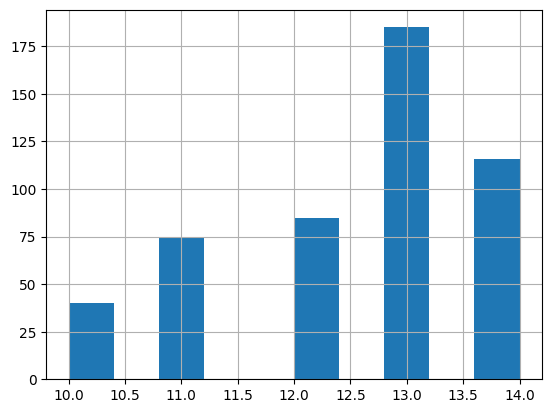

In [82]:
raw_seqns_for_file_with_activities['pep_len'].hist()

In [83]:
raw_seqns_for_file_with_activities = raw_seqns_for_file_with_activities[(raw_seqns_for_file_with_activities['pep_len'] >= 6)&(raw_seqns_for_file_with_activities['pep_len'] <= 40)]

In [84]:
raw_seqns_for_file_with_activities.shape

(501, 46)

In [85]:
raw_seqns_for_file_with_activities['SEQUENCE'].nunique()

501

In [86]:
all_for_file_with_activities_2mers = seqns2kmers(sequences_for_file_with_activities, min_len=2, max_len=2, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'IL': 1, 'LP': 1, 'PW': 3, 'WK': 1, 'KW': 1, 'WP': 2, 'WW': 1, 'WR': 1, 'RR': 1})
defaultdict(<class 'int'>, {'IL': 1, 'LA': 1, 'AW': 3, 'WK': 1, 'KW': 1, 'WA': 2, 'WW': 1, 'WR': 1, 'RR': 1})
defaultdict(<class 'int'>, {'LL': 3, 'LP': 1, 'PI': 1, 'IV': 1, 'VG': 1, 'GN': 1, 'NL': 1, 'LK': 1, 'KS': 1, 'SL': 1})
defaultdict(<class 'int'>, {'ID': 1, 'DW': 1, 'WK': 1, 'KK': 1, 'KL': 1, 'LL': 1, 'LD': 1, 'DA': 1, 'AA': 1, 'AK': 1, 'KQ': 1, 'QI': 1, 'IL': 1})
defaultdict(<class 'int'>, {'IL': 2, 'LG': 2, 'GT': 1, 'TI': 1, 'GL': 1, 'LL': 1, 'LK': 1, 'KS': 1, 'SL': 1})
defaultdict(<class 'int'>, {'RR': 2, 'RW': 2, 'WK': 1, 'KI': 1, 'IV': 1, 'VV': 1, 'VI': 1, 'IR': 1, 'WR': 1})
defaultdict(<class 'int'>, {'FL': 1, 'LS': 1, 'SG': 1, 'GI': 1, 'IV': 1, 'VG': 1, 'GM': 1, 'ML': 1, 'LG': 1, 'GK': 1, 'KL': 1, 'LF': 1})
defaultdict(<class 'int'>, {'HF': 1, 'FL': 1, 'LG': 1, 'GT': 1, 'TL': 1, 'LV': 1, 'VN': 1, 'NL': 1, 'LA': 1, 'AK': 1, 'KK': 1, 'KI': 1, 'IL': 1})
defaultdict(

In [87]:
len(all_for_file_with_activities_2mers)

501

In [88]:
all_for_file_with_activities_2mers_hdr = collect_kmers(all_for_file_with_activities_2mers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 376990.73it/s]


In [89]:
all_for_file_with_activities_2mers_vecs = gen_kmers_vector(all_for_file_with_activities_2mers_hdr, all_for_file_with_activities_2mers)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 86825.32it/s]


In [90]:
np.unique(all_for_file_with_activities_2mers_vecs, axis=0).shape

(485, 290)

In [91]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_2mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Get duplicate row indices
duplicate_mask = counts[unique_inverse] > 1  # Mask to identify duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Get the indices of duplicate rows

# Create pairs of duplicate indices
from collections import defaultdict

duplicates_dict = defaultdict(list)

# Group indices of duplicates by their unique representation
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# Convert to list of pairs
duplicate_pairs = [tuple(indices) for indices in duplicates_dict.values() if len(indices) > 1]

# Print duplicate pairs
for pair in duplicate_pairs:
    print(pair)
    print(raw_seqns_for_file_with_activities.loc[list(pair), ['SEQUENCE', 'binary_activity', 'molar_concentration_mean']])

(21, 22)
         SEQUENCE binary_activity molar_concentration_mean
21  ILPWKWAWWPWRR             0.0                     15.0
22  ILPWKWPWWAWRR             0.0                     25.0
(47, 48)
         SEQUENCE binary_activity molar_concentration_mean
47  ILAWKWAWWPWRR             0.0                     25.0
48  ILAWKWPWWAWRR             0.0                     50.0
(71, 73)
         SEQUENCE binary_activity molar_concentration_mean
71  ILSLRWRWKWWKK             0.0                     68.0
73  ILSLRWRWWKWKK             0.0                     32.0
(86, 347)
          SEQUENCE binary_activity molar_concentration_mean
86   GLLSALSLLGKLL             1.0                      3.1
347  GLLSLLSALGKLL             0.0                     25.0
(87, 346)
          SEQUENCE binary_activity molar_concentration_mean
87   GLLSLASLLGKLL             1.0                      3.1
346  GLASLLSLLGKLL             0.0                     25.0
(104, 105)
           SEQUENCE binary_activity molar_concentra

In [92]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_2mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Identify duplicate rows
duplicate_mask = counts[unique_inverse] > 1  # Mask for duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Indices of duplicate rows

# Group duplicate indices by their unique identifier
duplicates_dict = defaultdict(list)
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# DataFrame containing original data
df = raw_seqns_for_file_with_activities.copy(deep=True)  # Assuming this contains 'binary_activity'

# Determine which duplicate row to keep
rows_to_keep = set()
rows_to_drop = set()

for indices in duplicates_dict.values():
    if len(indices) > 1:  # Only process actual duplicates
        # Extract the subset of duplicates
        subset = df.loc[indices, ['binary_activity']]

        # Find the index of the row with the maximum binary_activity
        max_idx = subset['binary_activity'].idxmax()

        # Keep this row and mark others for removal
        rows_to_keep.add(max_idx)
        rows_to_drop.update(set(indices) - {max_idx})
    else:
        # If only one occurrence, keep it
        rows_to_keep.add(indices[0])

# Create a new DataFrame without the duplicate rows
df_cleaned = df.drop(index=rows_to_drop)

# Print the final shape
print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")

Original shape: (501, 46), New shape: (485, 46)


In [93]:
df_cleaned

,ID,UNIRPROT - ID,PDB NAME,SEQUENCE,TARGET ACTIVITY - CONCENTRATION,TARGET ACTIVITY - UNIT,COMPLEXITY,NAME,SYNTHESIS TYPE,TARGET GROUP,...,SYNERGY - REFERENCE,pep_id,monomer_mass,molar_concentration,extracted_relation,extracted_value,binary_activity,species_agg,molar_concentration_mean,pep_len
0,491,NaN,1G8C,ILPWKWPWWPWRR,2,µM,Monomer,"Cathelicidin-4, Indolicidin",Ribosomal,"Gram+,Gram-,Virus,Parasite,Cancer,Fungus,Mamma...",...,NaN,2201,1905,2.0,=,2,1.0,Klebsiella pneumoniae,2.0,13
1,493,NaN,1HR1,ILAWKWAWWAWRR,50,µM,Monomer,Cathelicidin-4/Indolicidin [P3A][P7A][P10A],Synthetic,"Gram+,Gram-,Fungus",...,NaN,2248,1827,50.0,=,50,0.0,Klebsiella pneumoniae,50.0,13
2,847,NaN,NaN,LLPIVGNLLKSLL,100,µM,Monomer,"Temporin-B, Temporin-1Tb\t",Ribosomal,"Gram+,Gram-,Virus,Parasite,Cancer,Fungus,Mamma...",...,NaN,4308,1391,100.0,=,100,0.0,Klebsiella pneumoniae,100.0,13
3,1584,NaN,NaN,IDWKKLLDAAKQIL,64,µM,Monomer,"Mastoparan-1, Mastoparan I, MPI, MP-1",Ribosomal,"Gram+,Gram-,Cancer,Fungus,Mammalian Cell",...,NaN,9450,1653,64.0,=,64,0.0,Klebsiella pneumoniae,64.0,14
4,1585,NaN,NaN,ILGTILGLLKSL,128,µM,Monomer,"Polybia-CP, Polybia chemotactic peptide, Venom...",Ribosomal,"Gram+,Gram-,Fungus,Mammalian Cell",...,NaN,9486,1239,128.0,=,128,0.0,Klebsiella pneumoniae,128.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,19011,NaN,NaN,KAIAAFAKKFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13F], MpVT4",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75146,1206,41.45936981757877,>,50.0,0.0,Klebsiella pneumoniae,41.45936981757877,11
497,19012,NaN,NaN,KAIAAFAKKFFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13FF], MpVT5",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75152,1353,36.95491500369549,>,50.0,0.0,Klebsiella pneumoniae,36.95491500369549,12
498,19013,NaN,NaN,KAIAAFAKALFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K12A,F14Ins], MpVT6",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75158,1262,39.61965134706814,>,50.0,0.0,Klebsiella pneumoniae,39.61965134706814,12
499,19014,NaN,NaN,KAIAAFAAKLFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K11A,F14Ins], MpVT7",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75164,1262,39.61965134706814,>,50.0,0.0,Klebsiella pneumoniae,39.61965134706814,12


In [94]:
sequences_for_file_with_activities = df_cleaned[sequence_column].to_list()

In [95]:
all_for_file_with_activities_2mers = seqns2kmers(sequences_for_file_with_activities, min_len=2, max_len=2, shift=1, normalize=False, binarized=False)
all_for_file_with_activities_2mers_vecs = gen_kmers_vector(all_for_file_with_activities_2mers_hdr, all_for_file_with_activities_2mers)

defaultdict(<class 'int'>, {'IL': 1, 'LP': 1, 'PW': 3, 'WK': 1, 'KW': 1, 'WP': 2, 'WW': 1, 'WR': 1, 'RR': 1})
defaultdict(<class 'int'>, {'IL': 1, 'LA': 1, 'AW': 3, 'WK': 1, 'KW': 1, 'WA': 2, 'WW': 1, 'WR': 1, 'RR': 1})
defaultdict(<class 'int'>, {'LL': 3, 'LP': 1, 'PI': 1, 'IV': 1, 'VG': 1, 'GN': 1, 'NL': 1, 'LK': 1, 'KS': 1, 'SL': 1})
defaultdict(<class 'int'>, {'ID': 1, 'DW': 1, 'WK': 1, 'KK': 1, 'KL': 1, 'LL': 1, 'LD': 1, 'DA': 1, 'AA': 1, 'AK': 1, 'KQ': 1, 'QI': 1, 'IL': 1})
defaultdict(<class 'int'>, {'IL': 2, 'LG': 2, 'GT': 1, 'TI': 1, 'GL': 1, 'LL': 1, 'LK': 1, 'KS': 1, 'SL': 1})
defaultdict(<class 'int'>, {'RR': 2, 'RW': 2, 'WK': 1, 'KI': 1, 'IV': 1, 'VV': 1, 'VI': 1, 'IR': 1, 'WR': 1})
defaultdict(<class 'int'>, {'FL': 1, 'LS': 1, 'SG': 1, 'GI': 1, 'IV': 1, 'VG': 1, 'GM': 1, 'ML': 1, 'LG': 1, 'GK': 1, 'KL': 1, 'LF': 1})
defaultdict(<class 'int'>, {'HF': 1, 'FL': 1, 'LG': 1, 'GT': 1, 'TL': 1, 'LV': 1, 'VN': 1, 'NL': 1, 'LA': 1, 'AK': 1, 'KK': 1, 'KI': 1, 'IL': 1})
defaultdict(

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:00<00:00, 115123.79it/s]


In [96]:
# Ev
# Convert binary_activity column to numeric, handling potential string values
df_cleaned["binary_activity"] = pd.to_numeric(df_cleaned["binary_activity"], errors='coerce')

# Ensure the values are properly converted to integers
binary_activity_array = df_cleaned["binary_activity"].fillna(0).astype(float).round().astype(int).to_numpy()

# Save as NPZ file
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity=binary_activity_array)

In [97]:
binary_activity_array = df_cleaned["binary_activity"].astype(int).to_numpy()
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity = binary_activity_array)

In [98]:
np.savez(npz_file_with_activities, vectors=all_for_file_with_activities_2mers_vecs)

In [99]:
binary_activity_array.shape

(485,)

In [100]:
all_for_file_with_activities_2mers_vecs.shape

(485, 290)

In [101]:
np.unique(all_for_file_with_activities_2mers_vecs, axis=0).shape

(485, 290)

In [102]:
indices_for_file_with_activities_2mers = [str(i+1) for i in range(all_for_file_with_activities_2mers_vecs.shape[0])]

In [103]:
desc_2mers_hdr = collect_kmers(all_for_file_with_activities_2mers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:00<00:00, 337576.74it/s]


In [104]:
write_hdr(desc_2mers_hdr, open(hdr_for_file_with_activities, "w"))

In [105]:
len(desc_2mers_hdr)

290

#### Model

In [167]:
vectors_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/2mers.npz"]
results_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/prediction_2mers.csv"]
activities_path = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/binary_activity.npz"
pickle_path = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/QSAR/"

In [168]:
for vec, res in tqdm(zip(vectors_path, results_path)):
    benchmark(vec, res, activities_path, pickle_path, use_mlp=False)

1it [00:17, 17.54s/it]


In [169]:
# File path
file_path = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/QSAR/model_RF_2mers.pickle"

# Load the model
with open(file_path, "rb") as f:
    model = pickle.load(f)

# Print the loaded model (optional)
print(model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150))])


In [170]:
!head /data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/prediction_2mers.csv

BA_SVM,ROCAUC_SVM,BA_RF,ROCAUC_RF
0.6734817813765182,0.7226720647773279,0.6176113360323886,0.7587044534412957


### Generate 3mers

In [171]:
hdr_for_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/3mers.hdr"
npz_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/3mers.npz"
svm_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/3mers.svm"
simplified_hdr_file_with_activities = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/3mers_simplified.hdr"

In [172]:
raw_seqns_for_file_with_activities = pd.read_csv(file_with_activities, dtype=str)
sequences_for_file_with_activities = raw_seqns_for_file_with_activities[sequence_column].to_list()

In [173]:
raw_seqns_for_file_with_activities.index

RangeIndex(start=0, stop=501, step=1)

In [174]:
raw_seqns_for_file_with_activities.shape

(501, 46)

In [175]:
raw_seqns_for_file_with_activities['SEQUENCE'].nunique()

501

In [176]:
all_for_file_with_activities_3mers = seqns2kmers(sequences_for_file_with_activities, min_len=3, max_len=3, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'ILP': 1, 'LPW': 1, 'PWK': 1, 'WKW': 1, 'KWP': 1, 'WPW': 2, 'PWW': 1, 'WWP': 1, 'PWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'ILA': 1, 'LAW': 1, 'AWK': 1, 'WKW': 1, 'KWA': 1, 'WAW': 2, 'AWW': 1, 'WWA': 1, 'AWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'LLP': 1, 'LPI': 1, 'PIV': 1, 'IVG': 1, 'VGN': 1, 'GNL': 1, 'NLL': 1, 'LLK': 1, 'LKS': 1, 'KSL': 1, 'SLL': 1})
defaultdict(<class 'int'>, {'IDW': 1, 'DWK': 1, 'WKK': 1, 'KKL': 1, 'KLL': 1, 'LLD': 1, 'LDA': 1, 'DAA': 1, 'AAK': 1, 'AKQ': 1, 'KQI': 1, 'QIL': 1})
defaultdict(<class 'int'>, {'ILG': 2, 'LGT': 1, 'GTI': 1, 'TIL': 1, 'LGL': 1, 'GLL': 1, 'LLK': 1, 'LKS': 1, 'KSL': 1})
defaultdict(<class 'int'>, {'RRW': 1, 'RWK': 1, 'WKI': 1, 'KIV': 1, 'IVV': 1, 'VVI': 1, 'VIR': 1, 'IRW': 1, 'RWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'FLS': 1, 'LSG': 1, 'SGI': 1, 'GIV': 1, 'IVG': 1, 'VGM': 1, 'GML': 1, 'MLG': 1, 'LGK': 1, 'GKL': 1, 'KLF': 1})
defaultdict(<class 'int'>, {'HFL': 1, 'FLG': 1, 'LGT': 1, 'GTL': 1,

In [177]:
len(all_for_file_with_activities_3mers)

501

In [178]:
all_for_file_with_activities_3mers_hdr = collect_kmers(all_for_file_with_activities_3mers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 254400.28it/s]


In [179]:
all_for_file_with_activities_3mers_vecs = gen_kmers_vector(all_for_file_with_activities_3mers_hdr, all_for_file_with_activities_3mers)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 67820.37it/s]


In [180]:
np.unique(all_for_file_with_activities_3mers_vecs, axis=0).shape

(498, 1128)

In [181]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_3mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Get duplicate row indices
duplicate_mask = counts[unique_inverse] > 1  # Mask to identify duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Get the indices of duplicate rows

# Create pairs of duplicate indices
from collections import defaultdict

duplicates_dict = defaultdict(list)

# Group indices of duplicates by their unique representation
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# Convert to list of pairs
duplicate_pairs = [tuple(indices) for indices in duplicates_dict.values() if len(indices) > 1]

# Print duplicate pairs
for pair in duplicate_pairs:
    print(pair)
    print(raw_seqns_for_file_with_activities.loc[list(pair), ['SEQUENCE', 'binary_activity', 'molar_concentration_mean']])

(244, 247)
        SEQUENCE binary_activity molar_concentration_mean
244  LKWLKKLLKKL             1.0          1.4194464158978
247  LKKLLKWLKKL             1.0          1.4194464158978
(245, 248)
        SEQUENCE binary_activity molar_concentration_mean
245  LLKWLKKLLKK             1.0          2.8388928317956
248  LLKKLLKWLKK             1.0          2.8388928317956
(246, 249)
        SEQUENCE binary_activity molar_concentration_mean
246  KLLKWLKKLLK             1.0          1.4194464158978
249  KLLKKLLKWLK             1.0          1.4194464158978


In [182]:
# Convert array to tuple format to use np.unique properly
_, unique_inverse, counts = np.unique(all_for_file_with_activities_3mers_vecs, axis=0, return_inverse=True, return_counts=True)

# Identify duplicate rows
duplicate_mask = counts[unique_inverse] > 1  # Mask for duplicate rows
duplicate_indices = np.where(duplicate_mask)[0]  # Indices of duplicate rows

# Group duplicate indices by their unique identifier
duplicates_dict = defaultdict(list)
for index, unique_id in enumerate(unique_inverse):
    duplicates_dict[unique_id].append(index)

# DataFrame containing original data
df = raw_seqns_for_file_with_activities.copy(deep=True)  # Assuming this contains 'binary_activity'

# Determine which duplicate row to keep
rows_to_keep = set()
rows_to_drop = set()

for indices in duplicates_dict.values():
    if len(indices) > 1:  # Only process actual duplicates
        # Extract the subset of duplicates
        subset = df.loc[indices, ['binary_activity']]

        # Find the index of the row with the maximum binary_activity
        max_idx = subset['binary_activity'].idxmax()

        # Keep this row and mark others for removal
        rows_to_keep.add(max_idx)
        rows_to_drop.update(set(indices) - {max_idx})
    else:
        # If only one occurrence, keep it
        rows_to_keep.add(indices[0])

# Create a new DataFrame without the duplicate rows
df_cleaned = df.drop(index=rows_to_drop)

# Print the final shape
print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")

Original shape: (501, 46), New shape: (498, 46)


In [183]:
df_cleaned

,ID,UNIRPROT - ID,PDB NAME,SEQUENCE,TARGET ACTIVITY - CONCENTRATION,TARGET ACTIVITY - UNIT,COMPLEXITY,NAME,SYNTHESIS TYPE,TARGET GROUP,...,SYNERGY - REFERENCE,pep_id,monomer_mass,molar_concentration,extracted_relation,extracted_value,binary_activity,species_agg,molar_concentration_mean,pep_len
0,491,NaN,1G8C,ILPWKWPWWPWRR,2,µM,Monomer,"Cathelicidin-4, Indolicidin",Ribosomal,"Gram+,Gram-,Virus,Parasite,Cancer,Fungus,Mamma...",...,NaN,2201,1905,2.0,=,2,1.0,Klebsiella pneumoniae,2.0,13
1,493,NaN,1HR1,ILAWKWAWWAWRR,50,µM,Monomer,Cathelicidin-4/Indolicidin [P3A][P7A][P10A],Synthetic,"Gram+,Gram-,Fungus",...,NaN,2248,1827,50.0,=,50,0.0,Klebsiella pneumoniae,50.0,13
2,847,NaN,NaN,LLPIVGNLLKSLL,100,µM,Monomer,"Temporin-B, Temporin-1Tb\t",Ribosomal,"Gram+,Gram-,Virus,Parasite,Cancer,Fungus,Mamma...",...,NaN,4308,1391,100.0,=,100,0.0,Klebsiella pneumoniae,100.0,13
3,1584,NaN,NaN,IDWKKLLDAAKQIL,64,µM,Monomer,"Mastoparan-1, Mastoparan I, MPI, MP-1",Ribosomal,"Gram+,Gram-,Cancer,Fungus,Mammalian Cell",...,NaN,9450,1653,64.0,=,64,0.0,Klebsiella pneumoniae,64.0,14
4,1585,NaN,NaN,ILGTILGLLKSL,128,µM,Monomer,"Polybia-CP, Polybia chemotactic peptide, Venom...",Ribosomal,"Gram+,Gram-,Fungus,Mammalian Cell",...,NaN,9486,1239,128.0,=,128,0.0,Klebsiella pneumoniae,128.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,19011,NaN,NaN,KAIAAFAKKFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13F], MpVT4",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75146,1206,41.45936981757877,>,50.0,0.0,Klebsiella pneumoniae,41.45936981757877,11
497,19012,NaN,NaN,KAIAAFAKKFFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [L13FF], MpVT5",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75152,1353,36.95491500369549,>,50.0,0.0,Klebsiella pneumoniae,36.95491500369549,12
498,19013,NaN,NaN,KAIAAFAKALFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K12A,F14Ins], MpVT6",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75158,1262,39.61965134706814,>,50.0,0.0,Klebsiella pneumoniae,39.61965134706814,12
499,19014,NaN,NaN,KAIAAFAAKLFI,>50,µg/ml,Monomer,"Mastoparan-T (4-14) [K11A,F14Ins], MpVT7",Synthetic,"Gram+,Gram-,Mammalian Cell",...,NaN,75164,1262,39.61965134706814,>,50.0,0.0,Klebsiella pneumoniae,39.61965134706814,12


In [184]:
sequences_for_file_with_activities = df_cleaned[sequence_column].to_list()

In [185]:
# Ev
# Convert binary_activity column to numeric, handling potential string values
df_cleaned["binary_activity"] = pd.to_numeric(df_cleaned["binary_activity"], errors='coerce')

# Ensure the values are properly converted to integers
binary_activity_array = df_cleaned["binary_activity"].fillna(0).astype(float).round().astype(int).to_numpy()

# Save as NPZ file
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity=binary_activity_array)

In [186]:
binary_activity_array = df_cleaned["binary_activity"].astype(int).to_numpy()
npz_binary_activity = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/binary_activity.npz"
np.savez(npz_binary_activity, binary_activity = binary_activity_array)

In [187]:
np.savez(npz_file_with_activities, vectors=all_for_file_with_activities_3mers_vecs)

In [188]:
binary_activity_array.shape

(498,)

In [189]:
all_for_file_with_activities_3mers_vecs.shape

(501, 1128)

In [190]:
all_for_file_with_activities_3mers = seqns2kmers(df_cleaned['SEQUENCE'], min_len=3, max_len=3, shift=1, normalize=False, binarized=False)

defaultdict(<class 'int'>, {'ILP': 1, 'LPW': 1, 'PWK': 1, 'WKW': 1, 'KWP': 1, 'WPW': 2, 'PWW': 1, 'WWP': 1, 'PWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'ILA': 1, 'LAW': 1, 'AWK': 1, 'WKW': 1, 'KWA': 1, 'WAW': 2, 'AWW': 1, 'WWA': 1, 'AWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'LLP': 1, 'LPI': 1, 'PIV': 1, 'IVG': 1, 'VGN': 1, 'GNL': 1, 'NLL': 1, 'LLK': 1, 'LKS': 1, 'KSL': 1, 'SLL': 1})
defaultdict(<class 'int'>, {'IDW': 1, 'DWK': 1, 'WKK': 1, 'KKL': 1, 'KLL': 1, 'LLD': 1, 'LDA': 1, 'DAA': 1, 'AAK': 1, 'AKQ': 1, 'KQI': 1, 'QIL': 1})
defaultdict(<class 'int'>, {'ILG': 2, 'LGT': 1, 'GTI': 1, 'TIL': 1, 'LGL': 1, 'GLL': 1, 'LLK': 1, 'LKS': 1, 'KSL': 1})
defaultdict(<class 'int'>, {'RRW': 1, 'RWK': 1, 'WKI': 1, 'KIV': 1, 'IVV': 1, 'VVI': 1, 'VIR': 1, 'IRW': 1, 'RWR': 1, 'WRR': 1})
defaultdict(<class 'int'>, {'FLS': 1, 'LSG': 1, 'SGI': 1, 'GIV': 1, 'IVG': 1, 'VGM': 1, 'GML': 1, 'MLG': 1, 'LGK': 1, 'GKL': 1, 'KLF': 1})
defaultdict(<class 'int'>, {'HFL': 1, 'FLG': 1, 'LGT': 1, 'GTL': 1,

In [191]:
all_for_file_with_activities_3mers_hdr = collect_kmers(all_for_file_with_activities_3mers)
all_for_file_with_activities_3mers_vecs = gen_kmers_vector(all_for_file_with_activities_3mers_hdr, all_for_file_with_activities_3mers)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:00<00:00, 73210.31it/s]


In [192]:
np.unique(all_for_file_with_activities_3mers_vecs, axis=0).shape

(498, 1128)

In [193]:
vectors_path ='/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/3mers.npz'

In [194]:
np.savez(vectors_path, vectors=all_for_file_with_activities_3mers_vecs)

In [195]:
indices_for_file_with_activities_3mers = [str(i+1) for i in range(all_for_file_with_activities_3mers_vecs.shape[0])]

In [196]:
vectors_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/3mers.npz"]
results_path = ["/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/prediction_3mers.csv"]
activities_path = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/binary_activity.npz"
pickle_path = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/QSAR/"

In [197]:
for vec, res in tqdm(zip(vectors_path, results_path)):
    benchmark(vec, res, activities_path, pickle_path, use_mlp=False)

1it [00:53, 53.02s/it]


In [198]:
# File path
file_path = "/data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/QSAR/model_RF_3mers.pickle"

# Load the model
with open(file_path, "rb") as f:
    model = pickle.load(f)

# Print the loaded model (optional)
print(model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features='log2',
                                        n_estimators=400))])


In [199]:
!head /data/emilova/peptides/src/data/DBAASP/test_for_k_pneumoniae_alternative_data_extraction_mole/prediction_3mers.csv

BA_SVM,ROCAUC_SVM,BA_RF,ROCAUC_RF
0.648954678362573,0.6845079597141,0.6167259584145549,0.7512301007147498


---